# 0.0. Entender o Problema

-- Objetivo do Problema: 1.0. Previsao do primeiro destino que um usuário irá escolher

    -- Porque?
        -- Qual o tipo de modelo de negócio do Airbnb?
            -- Marketplace (Conectar pessoas que oferecem acomodações com pessoas que estão procurando acomodações)
            
            -- Oferta (pessoas oferecendo acomodações)
                -- Tamanho do portfólio
                -- Diversidade/Densidade do portfólio
                -- Preço Médio
            
            -- Demanda (pessoas procurando acomodações)
                -- Número de Usuários
                -- LTV (Lifetime Value)
                -- CAC (Cliente Acquisition Cost)
                
            -- Gross Revenue = (Fee*Numero cliente) - CAC
            
    -- Proposta de Solução
        -- Modelo de Previsão do primeiro destino de um novo usuário
        -- 1.0. Predições e salva em tabela de banco de dados
        -- 2.0 API
            -- Input: Usuário e Suas Características
            -- Output: Usuário e Suas características com a predição do destino.
            
       

# Ciclo 01: End to End

## 0.0 Imports

### 0.1 Helper Functions

In [82]:
import pandas as pd
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt
from keras  import models as ml
from keras import layers as l

### 0.2 Loading Data

In [5]:
!ls -s data_set

total 4168
4168 training_users.csv.zip


In [4]:
df_raw = pd.read_csv('data_set/training_users.csv', low_memory = True)
df_raw.shape

(213451, 16)

In [9]:
#df_sessions = pd.read_csv('data_set/sessions.csv', low_memory=True)
#df_sessions.shape

#-- Preciso fazer uma granularidade do tipo Usuário/Seção ou só Usuário

#-- O número de usuários por granularidade

#df_sessions.sort_values('user_id').head()
#ordena por usuário e lista os primeiros

#df_sessions(df_sessions['user_id']=='00023iyk91')[['user_id','action']].groupby('user_id').count()

#Vai mostrar quantas ações foi feita pelo usuário.

#df_sessions(df_sessions['user_id']=='00023iyk91')[['user_id','action']].groupby('user_id').value_counts()
#conta quantas linhas eu tenho por usuário e por ação.

#Voltamos depois nesses dados.

## 1.0 Data Description

In [10]:
df1 = df_raw.copy()

In [12]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


#### 1.1 Data Type

In [13]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

#### 1.2 NA Check

In [14]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [16]:
# Removendo dados faltantes
df1 = df1.dropna()
df1.shape

(68171, 16)

#### 1.3 Change Data Type

In [26]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )


# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'],format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

#### 1.4 Check Balanced Data

In [28]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

## 2.0. Data Filtering

In [29]:
df2 = df1.copy()

#### 2.1 Filtering Rows

#### 2.2 Columns Selection

## 3.0 Data Preparation

In [31]:
df3 = df2.copy()

In [67]:
# Dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id', 'country_destination'], axis = 1))

#Join id and country destination
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummy], axis = 1)

## 4.0 Feature Selection

In [68]:
cols_drop=['date_account_created', 'timestamp_first_active', 'date_first_booking'] #original dates
df4 = df3.drop(cols_drop, axis = 1)

In [33]:
df4.sample().T

,112523
id,kd5ds0hs7k
gender,FEMALE
age,30
signup_method,facebook
signup_flow,0
language,en
affiliate_channel,direct
affiliate_provider,direct
first_affiliate_tracked,untracked
signup_app,Web


In [69]:
X = df4.drop('country_destination', axis = 1)
y = df4['country_destination'].copy()

In [70]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

## 5.0 Machine Learning Model - Neural Network MLP

In [71]:
#Split dataset into training and test

X_train, X_test, y_train, y_test = ms.train_test_split (X,y, test_size = 0.2, random_state = 32)

In [72]:
x_train = X_train.drop('id', axis = 1)
x_test = X_test.drop('id', axis = 1)

In [73]:
x_train.shape

(54536, 112)

In [74]:
#Model Definition

model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

#Model Compile
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x_train, y_train_nn, epochs = 100)

Epoch 1/100
1705/1705 [==============================] - 18s 2ms/step - loss: 1.3691 - accuracy: 0.7060
Epoch 2/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2705 - accuracy: 0.7055
Epoch 3/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2426 - accuracy: 0.7062
Epoch 4/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2235 - accuracy: 0.7064
Epoch 5/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1901 - accuracy: 0.7067
Epoch 6/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1810 - accuracy: 0.7088
Epoch 7/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1673 - accuracy: 0.7073
Epoch 8/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1424 - accuracy: 0.7094
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1456 - accuracy: 0.7075
Epoch 10/100
1705/1705 [==============================] - 3s 2ms/step - 

1705/1705 [==============================] - 3s 2ms/step - loss: 1.0948 - accuracy: 0.7120
Epoch 80/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0934 - accuracy: 0.7119
Epoch 81/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0948 - accuracy: 0.7128
Epoch 82/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0958 - accuracy: 0.7109
Epoch 83/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0933 - accuracy: 0.7128
Epoch 84/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1046 - accuracy: 0.7089
Epoch 85/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1027 - accuracy: 0.7091
Epoch 86/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0966 - accuracy: 0.7109
Epoch 87/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.0967 - accuracy: 0.7126
Epoch 88/100
1705/1705 [==============================] - 4s 2ms/step - loss:

## 5.0 NN Performance

In [78]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()

yhat_nn = yhat_nn.reshape(1,-1)[0]

Accuracy: 0.7018701870187019


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

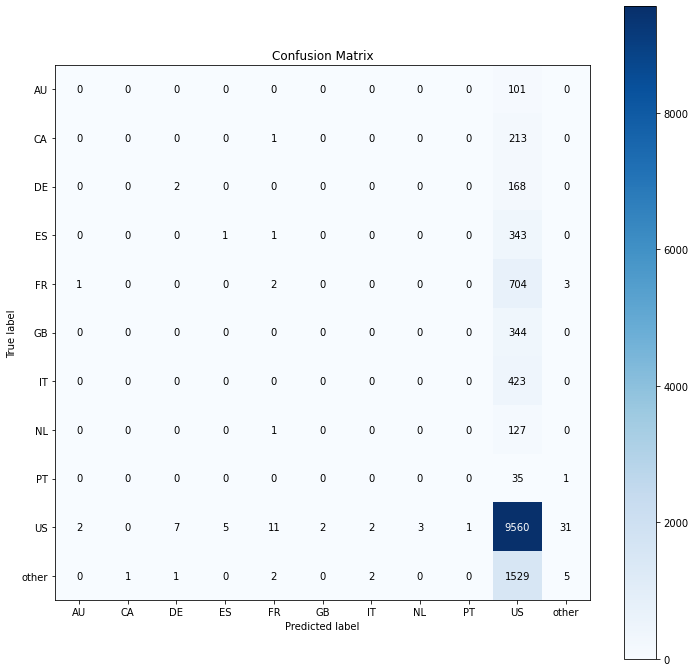

In [83]:
# accuracy
acc_nn = m.accuracy_score(y_test_nn,yhat_nn)
print('Accuracy: {}'.format(acc_nn))
# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize = (12,12))

# Balanced Accuray
# F-Score Balanced
# Recall-Precison
# ROC 
# Kappa Metrics
# Matthew Metrics